In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from einops import rearrange
from math import ceil

from layers.Embed import PositionalEmbedding2D

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def dispatch(inp, gates):
    # sort experts
    _, index_sorted_experts = torch.nonzero(gates).sort(0)
    # get according batch index for each expert
    _batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
    _part_sizes = (gates > 0).sum(0).tolist()
    # assigns samples to experts whose gate is nonzero
    # expand according to batch index so we can just split by _part_sizes
    inp_exp = inp[_batch_index].squeeze(1)
    return torch.split(inp_exp, _part_sizes, dim=0)

def combine(expert_out, gates, multiply_by_gates=True):
    # sort experts
    sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
    _, _expert_index = sorted_experts.split(1, dim=1)
    # get according batch index for each expert
    _batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
    gates_exp = gates[_batch_index.flatten()]
    _nonzero_gates = torch.gather(gates_exp, 1, _expert_index)
    # apply exp to expert outputs, so we are not longer in log space
    stitched = torch.cat(expert_out, 0).exp()
    if multiply_by_gates:
        stitched = torch.einsum("bcld,bc -> bcld", stitched, _nonzero_gates)
    zeros = torch.zeros(gates.size(0), expert_out[-1].size(1), expert_out[-1].size(2), expert_out[-1].size(3),
                        requires_grad=True, device=stitched.device)
    # combine samples that have been processed by the same k experts
    combined = zeros.index_add(0, _batch_index, stitched.float())
    # add eps to all zero values in order to avoid nans when going back to log space
    combined[combined == 0] = np.finfo(float).eps
    # back to log space
    return combined.log()

In [7]:
class AdaptiveMultiScalePeriodicPatchEmbedding(nn.Module):
    def __init__(self, seq_len, num_features, top_k=5, d_model=512, dropout=0.):
        super(AdaptiveMultiScalePeriodicPatchEmbedding, self).__init__()
        self.seq_len = seq_len
        self.top_k = top_k
        # get the patch sizes
        self.patch_sizes = self.get_patch_sizes(seq_len)
        # AFNO1D parameters
        self.start_fc = nn.Linear(num_features, 1)
        self.num_freqs = seq_len // 2
      
        self.scale = 1 / d_model
        self.w1 = nn.Parameter(self.scale * torch.randn(2, self.num_freqs, self.num_freqs * 4))
        self.b1 = nn.Parameter(self.scale * torch.randn(2, self.num_freqs * 4))
        self.w2 = nn.Parameter(self.scale * torch.randn(2, self.num_freqs * 4, self.num_freqs))
        self.b2 = nn.Parameter(self.scale * torch.randn(2, self.num_freqs))
        # Noise parameters
        self.w_gate = nn.Parameter(torch.zeros(self.num_freqs, len(self.patch_sizes)))
        self.w_noise = nn.Parameter(torch.zeros(self.num_freqs, len(self.patch_sizes)))
        # Patch Embedding parameters
        self.value_embeddings = nn.ModuleList()
        self.padding_patch_layers = nn.ModuleList()
        for patch_size in self.patch_sizes:
            self.value_embeddings.append(nn.Linear(patch_size, d_model, bias=False))
            self.padding_patch_layers.append(nn.ReplicationPad1d((0, ceil(seq_len / patch_size) * patch_size - seq_len)))
        self.position_embedding = PositionalEmbedding2D(d_model, num_features, 512)
        self.dropout = nn.Dropout(dropout)
    
    def get_patch_sizes(self, seq_len):
        # get the period list, first element is inf if exclude_zero is False
        peroid_list = 1 / torch.fft.rfftfreq(seq_len)[1:]
        patch_sizes = peroid_list.floor().int().unique().detach().cpu().numpy()[::-1]
        # patch_sizes = peroid_list.ceil().int().unique().detach().cpu().numpy()[::-1]
        print(patch_sizes)
        return patch_sizes
    
    def afno1d_for_peroid_weights(self, x, training, noise_epsilon=1e-2):
        # x [B, L, C]
        B, L, C = x.shape

        x = self.start_fc(x).squeeze(-1) # [B, L]
        
        # if self.adaptive:

        # x = rearrange(x, 'B L C -> B C L') # [B, C, L] 
        xf = torch.fft.rfft(x, dim=-1, norm='ortho') # [B, L//2+1]
        # xf = torch.fft.rfft(x, dim=-1) # [B, L//2+1]
        xf_ac = xf[:, 1:] # [B, L//2]

        o1_real = F.relu(xf_ac.real @ self.w1[0] - xf_ac.imag @ self.w1[1] + self.b1[0])
        o1_imag = F.relu(xf_ac.imag @ self.w1[0] + xf_ac.real @ self.w1[1] + self.b1[1])
        o2_real = o1_real @ self.w2[0] - o1_imag @ self.w2[1] + self.b2[0]
        o2_imag = o1_imag @ self.w2[0] + o1_real @ self.w2[1] + self.b2[1]

        xf_ac = torch.stack([o2_real, o2_imag], dim=-1) # [B, L-1, 2]
        xf_ac = F.softshrink(xf_ac, lambd=0.01) # [B, L-1, 2]
        xf_ac = torch.view_as_complex(xf_ac) # [B, L-1]
        xf_ac = torch.abs(xf_ac) # [B, L-1]

        clean_logits = xf_ac @ self.w_gate
        if training:
            raw_noise_stddev = xf_ac @ self.w_noise
            noise_stddev = (F.softplus(raw_noise_stddev) + noise_epsilon)
            noise = torch.randn_like(clean_logits) * noise_stddev
            noisy_logits = clean_logits + noise
            logits = noisy_logits # [B, L-1]
        else:
            logits = clean_logits # [B, L-1]

        weights = logits # B, L-1

        top_weights, top_indices = torch.topk(weights, self.top_k, dim=-1) # [B, top_k]
        top_weights = F.softmax(top_weights, dim=-1) # [B, top_k]

        zeros = torch.zeros_like(weights) # [B, Ps]
        gates = zeros.scatter_(-1, top_indices, top_weights) # [B, Ps]

        return gates # [B, Ps]
    
    def patch_embedding(self, x, patch_size, index_of_patch):
        B, L, C = x.shape
        # do patching
        x = rearrange(x, 'B L C -> B C L') # [B, C, L]
        x = self.padding_patch_layers[index_of_patch](x)
        x = x.unfold(-1, patch_size, patch_size) # [B, C, L//patch_size, patch_size]
        x = self.value_embeddings[index_of_patch](x) + self.position_embedding(x) # [B, C, L, D]
        return self.dropout(x) # [B, C, L, D]

    def forward(self, x):
        gates = self.afno1d_for_peroid_weights(x, self.training) # [B, Ps]
        xs = dispatch(x, gates)
        _xs = []
        for i, patch_size in enumerate(self.patch_sizes):
            _xs.append(self.patch_embedding(xs[i], patch_size, i))
        return _xs, gates # Ps*[B, C, L, D], [bs, Ps]

In [ ]:
class MultiScalePeriodicPatchEmbedding(nn.Module): 
    def __init__(self, seq_len, num_features, top_k=5, d_model=512, dropout=0.):
        super(MultiScalePeriodicPatchEmbedding, self).__init__()
        self.seq_len = seq_len
        self.top_k = top_k
        # get the patch sizes
        self.patch_sizes, self.patch_indices_dic = self.get_patch_sizes(seq_len)
        # AFNO1D parameters
        self.start_fc = nn.Linear(num_features, 1)
        # Patch Embedding parameters
        self.value_embeddings = nn.ModuleList()
        self.padding_patch_layers = nn.ModuleList()
        for patch_size in self.patch_sizes:
            self.value_embeddings.append(nn.Linear(patch_size, d_model, bias=False))
            self.padding_patch_layers.append(nn.ReplicationPad1d((0, ceil(seq_len / patch_size) * patch_size - seq_len)))
        self.position_embedding = PositionalEmbedding2D(d_model, num_features, 512)
        self.dropout = nn.Dropout(dropout)
    
    def get_patch_sizes(self, seq_len):
        # get the period list, first element is inf if exclude_zero is False
        peroid_list = 1 / torch.fft.rfftfreq(seq_len)[1:]
        patch_sizes = peroid_list.floor().int().unique().detach().cpu().numpy()[::-1]
        # patch_sizes = peroid_list.ceil().int().unique().detach().cpu().numpy()[::-1]
        print(patch_sizes)
        patch_indices_dic = {}
        for i, period in enumerate(patch_sizes):
            patch_indices_dic[period] = torch.where(peroid_list == period)
        return patch_sizes, patch_indices_dic
    
    def afno1d_for_peroid_weights(self, x, training, noise_epsilon=1e-2):
        # x [B, L, C]
        B, L, C = x.shape

        x = self.start_fc(x).squeeze(-1) # [B, L]
        
        # x = rearrange(x, 'B L C -> B C L') # [B, C, L] 
        xf = torch.fft.rfft(x, dim=-1, norm='ortho') # [B, L//2+1]
        # xf = torch.fft.rfft(x, dim=-1) # [B, L//2+1]
        xf_ac = xf[:, 1:] # [B, L//2]

        xf_ac = torch.abs(xf_ac) # [B, L-1]

        periods_amp = []
        for patch_size in self.patch_sizes:
            indices = self.patch_indices_dic[patch_size]
            periods_amp.append(torch.max(xf_ac[:, indices], dim=-1).values)
        periods_amp = torch.stack(periods_amp, dim=-1)

        weights = periods_amp # B, L-1

        top_weights, top_indices = torch.topk(weights, self.top_k, dim=-1) # [B, top_k]
        top_weights = F.softmax(top_weights, dim=-1) # [B, top_k]

        zeros = torch.zeros_like(weights) # [B, Ps]
        gates = zeros.scatter_(-1, top_indices, top_weights) # [B, Ps]

        return gates # [B, Ps]
    
    def patch_embedding(self, x, patch_size, index_of_patch):
        B, L, C = x.shape
        # do patching
        x = rearrange(x, 'B L C -> B C L') # [B, C, L]
        x = self.padding_patch_layers[index_of_patch](x)
        x = x.unfold(-1, patch_size, patch_size) # [B, C, L//patch_size, patch_size]
        x = self.value_embeddings[index_of_patch](x) + self.position_embedding(x) # [B, C, L, D]
        return self.dropout(x) # [B, C, L, D]

    def forward(self, x):
        gates = self.afno1d_for_peroid_weights(x, self.training) # [B, Ps]
        xs = dispatch(x, gates)
        _xs = []
        for i, patch_size in enumerate(self.patch_sizes):
            _xs.append(self.patch_embedding(xs[i], patch_size, i))
        return _xs, gates # Ps*[B, C, L, D], [bs, Ps]

In [ ]:
class AdaptiveMultiScalePatchEmbedding(nn.Module):
    def __init__(self, seq_len, num_features, top_k=5, d_model=512, dropout=0.):
        super(AdaptiveMultiScalePatchEmbedding, self).__init__()
        self.seq_len = seq_len
        self.top_k = top_k
        # get the patch sizes
        self.patch_sizes = self.get_patch_sizes(seq_len)
        # AFNO1D parameters
        self.start_fc = nn.Linear(num_features, 1)
        self.num_freqs = seq_len // 2
        # Noise parameters
        self.w_gate = nn.Parameter(torch.zeros(self.num_freqs, len(self.patch_sizes)))
        self.w_noise = nn.Parameter(torch.zeros(self.num_freqs, len(self.patch_sizes)))
        # Patch Embedding parameters
        self.value_embeddings = nn.ModuleList()
        self.padding_patch_layers = nn.ModuleList()
        for patch_size in self.patch_sizes:
            self.value_embeddings.append(nn.Linear(patch_size, d_model, bias=False))
            self.padding_patch_layers.append(nn.ReplicationPad1d((0, ceil(seq_len / patch_size) * patch_size - seq_len)))
        self.position_embedding = PositionalEmbedding2D(d_model, num_features, 512)
        self.dropout = nn.Dropout(dropout)
    
    def get_patch_sizes(self, seq_len):
        # get the period list, first element is inf if exclude_zero is False
        patch_sizes = np.array([4, 8, 16, 32, 64])
        patch_sizes = np.array([7, 30, 90, 180, 360])
        # patch_sizes = peroid_list.ceil().int().unique().detach().cpu().numpy()[::-1]
        print(patch_sizes)
        return patch_sizes
    
    def afno1d_for_peroid_weights(self, x, training, noise_epsilon=1e-2):
        # x [B, L, C]
        B, L, C = x.shape

        x = self.start_fc(x).squeeze(-1) # [B, L]
        
        # if self.adaptive:

        # x = rearrange(x, 'B L C -> B C L') # [B, C, L] 
        xf = torch.fft.rfft(x, dim=-1, norm='ortho') # [B, L//2+1]
        # xf = torch.fft.rfft(x, dim=-1) # [B, L//2+1]
        xf_ac = xf[:, 1:] # [B, L//2]

        xf_ac = torch.abs(xf_ac) # [B, L-1]

        clean_logits = xf_ac @ self.w_gate
        if training:
            raw_noise_stddev = xf_ac @ self.w_noise
            noise_stddev = (F.softplus(raw_noise_stddev) + noise_epsilon)
            noise = torch.randn_like(clean_logits) * noise_stddev
            noisy_logits = clean_logits + noise
            logits = noisy_logits # [B, L-1]
        else:
            logits = clean_logits # [B, L-1]

        weights = logits # B, L-1

        top_weights, top_indices = torch.topk(weights, self.top_k, dim=-1) # [B, top_k]
        top_weights = F.softmax(top_weights, dim=-1) # [B, top_k]

        zeros = torch.zeros_like(weights) # [B, Ps]
        gates = zeros.scatter_(-1, top_indices, top_weights) # [B, Ps]

        return gates # [B, Ps]
    
    def patch_embedding(self, x, patch_size, index_of_patch):
        B, L, C = x.shape
        # do patching
        x = rearrange(x, 'B L C -> B C L') # [B, C, L]
        x = self.padding_patch_layers[index_of_patch](x)
        x = x.unfold(-1, patch_size, patch_size) # [B, C, L//patch_size, patch_size]
        x = self.value_embeddings[index_of_patch](x) + self.position_embedding(x) # [B, C, L, D]
        return self.dropout(x) # [B, C, L, D]

    def forward(self, x):
        gates = self.afno1d_for_peroid_weights(x, self.training) # [B, Ps]
        xs = dispatch(x, gates)
        _xs = []
        for i, patch_size in enumerate(self.patch_sizes):
            _xs.append(self.patch_embedding(xs[i], patch_size, i))
        return _xs, gates # Ps*[B, C, L, D], [bs, Ps]

{365: tensor([0]), 182: tensor([1]), 121: tensor([2]), 91: tensor([3]), 73: tensor([4]), 60: tensor([5]), 52: tensor([6]), 45: tensor([7]), 40: tensor([8]), 36: tensor([9]), 33: tensor([10]), 30: tensor([11]), 28: tensor([12]), 26: tensor([13]), 24: tensor([14]), 22: tensor([15]), 21: tensor([16]), 20: tensor([17]), 19: tensor([18]), 18: tensor([19]), 17: tensor([20]), 16: tensor([21]), 15: tensor([22, 23]), 14: tensor([24, 25]), 13: tensor([26, 27]), 12: tensor([28, 29]), 11: tensor([30, 31, 32]), 10: tensor([33, 34, 35]), 9: tensor([36, 37, 38, 39]), 8: tensor([40, 41, 42, 43, 44]), 7: tensor([45, 46, 47, 48, 49, 50, 51]), 6: tensor([52, 53, 54, 55, 56, 57, 58, 59]), 5: tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]), 4: tensor([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]), 3: tensor([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 

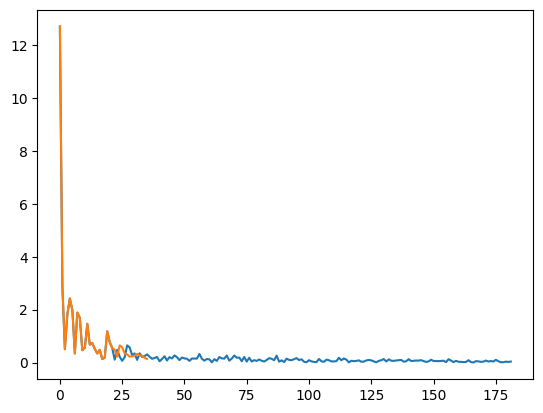

In [46]:
freqs = torch.fft.rfftfreq(365)
periods = 1 / freqs[1:]
periods_int = periods.floor().int()
peroids_indices_dic = {}
for i, period in enumerate(periods_int.unique().detach().cpu().numpy()[::-1]):
    peroids_indices_dic[period] = torch.where(periods_int == period)[0]
# indices = torch.where(periods_int == 3)
print(peroids_indices_dic)

# x = torch.randn(8, 365)
sst = pd.read_csv('./dataset/multivariate/oisst_lat_14.0_lon_112.0.csv')
sst = sst['sst'].values
x = torch.tensor(sst[-365:]).unsqueeze(0).float()

xf = torch.fft.rfft(x, dim=-1, norm='ortho')
xf_ac = xf[:, 1:]
xf_ac = torch.abs(xf_ac)
sns.lineplot(xf_ac[0].detach().cpu().numpy())

periods_amp = []
for patch_size in periods_int.unique().detach().cpu().numpy()[::-1]:
    indices = peroids_indices_dic[patch_size]
    print(indices, xf_ac[:, indices].max(-1).values)
    periods_amp.append(xf_ac[:, indices].max(-1).values)
periods_amp = torch.stack(periods_amp, dim=-1)
print(periods_amp.shape)
sns.lineplot(periods_amp[0].detach().cpu().numpy())
plt.show()

In [48]:
patch_sizes = np.array([4, 8, 16, 32, 64])
patch_sizes = np.array([7, 30, 90, 180, 360])
# patch_sizes = peroid_list.ceil().int().unique().detach().cpu().numpy()[::-1]
print(patch_sizes)

7


In [5]:
import re
import csv

def parse_experiment_block(block):
    # 提取实验设置和结果
    setting_pattern = re.compile(r'omdata(\d)_topk(\d+)_MSPT_0725+_custom_ftMS_sl\d+_ll48+_pl(\d+)_dm(\d+)_nh\d+_el(\d+)_dl\d+_df\d+_fc\d+_ebtimeF_dtTrue_\d+')
    rmse_pattern = re.compile(r'rmse:([\d\.]+)')
    mae_pattern = re.compile(r'mae:([\d\.]+)')
    r2_pattern = re.compile(r'r2_score:([\d\.]+)')
    
    setting_match = setting_pattern.search(block)
    rmse_match = rmse_pattern.search(block)
    mae_match = mae_pattern.search(block)
    r2_match = r2_pattern.search(block)

    # print(setting_match.groups())
    
    if setting_match and rmse_match and mae_match and r2_match:
        site = f'S{setting_match.group(1)}'
        k = setting_match.group(2)
        layers = setting_match.group(5)
        pred_len = setting_match.group(3)
        dim = setting_match.group(4)
        rmse = rmse_match.group(1)
        mae = mae_match.group(1)
        r2 = r2_match.group(1)
        
        return [site, int(pred_len), int(layers), int(dim), int(k), float(rmse), float(mae), float(r2)]
    else:
        return None

def main():
    input_file = './test_result.txt'
    output_file = './test_results.csv'
    
    with open(input_file, 'r') as file:
        content = file.read()
    
    # 分割每个实验结果块
    blocks = content.split('\n\n')
    
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Site', 'pred_len', 'layers', 'dim', 'k', 'rmse', 'mae', 'r2']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        
        for block in blocks:
            print(block)
            result = parse_experiment_block(block)
            # if result == None:
            #     print(block)
            print(result)
            if result:
                writer.writerow({
                    'Site': result[0],
                    'pred_len': result[1],
                    'layers': result[2],
                    'dim': result[3],
                    'k': result[4],
                    'rmse': result[5],
                    'mae': result[6],
                    'r2': result[7]
                })

if __name__ == "__main__":
    main()

omdata1_topk2_MSPT_0726_custom_ftMS_sl365_ll48_pl30_dm64_nh8_el1_dl1_df256_fc1_ebtimeF_dtTrue_20240701_0  
mse:0.43534767627716064, mae:0.518435001373291, rmse:0.6598088145256042, mape:0.018590420484542847, mspe:0.000569934316445142, rse:0.46119391918182373, r2_score:0.7566162941336726, acc:0.9814095795154572
corr:[38.050163 37.776966 37.6253   37.53494  37.883015 37.461403 37.67436
 37.5872   37.479706 37.675415 37.772    37.57973  37.345173 37.662666
 37.77369  37.860146 37.660816 37.94298  38.104412 37.81985  37.97887
 37.74801  37.94196  38.10723  38.262814 38.022453 38.167553 38.064198
 38.471405 38.09967 ]
None
omdata1_topk3_MSPT_0726_custom_ftMS_sl365_ll48_pl30_dm64_nh8_el1_dl1_df256_fc1_ebtimeF_dtTrue_20240701_0  
mse:0.4352788031101227, mae:0.5187742710113525, rmse:0.659756600856781, mape:0.018599284812808037, mspe:0.0005692435661330819, rse:0.4611574113368988, r2_score:0.7673157385669338, acc:0.981400715187192
corr:[38.108803 37.72203  37.61474  37.641476 37.884197 37.580246 

In [6]:
import csv

def sort_csv(input_file, output_file):
    with open(input_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        data = list(reader)
    
    # 排序数据
    data.sort(key=lambda x: (int(x['Site'][1]), int(x['pred_len']), int(x['layers']), int(x['dim']), int(x['k'])))
    
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Site', 'pred_len', 'layers', 'dim', 'k', 'rmse', 'mae', 'r2']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        writer.writerows(data)

if __name__ == "__main__":
    input_csv = './test_results.csv'
    output_csv = './test_sorted_results.csv'
    sort_csv(input_csv, output_csv)

In [8]:
import csv
from collections import defaultdict

def sort_and_average_csv(input_file, output_file):
    with open(input_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        data = list(reader)
    
    # 分组并计算平均值
    grouped_data = defaultdict(lambda: {'rmse': [], 'mae': [], 'r2': []})
    
    for row in data:
        key = (row['Site'], int(row['pred_len']), int(row['layers']), int(row['dim']), int(row['k']))
        grouped_data[key]['rmse'].append(float(row['rmse']))
        grouped_data[key]['mae'].append(float(row['mae']))
        grouped_data[key]['r2'].append(float(row['r2']))
    
    averaged_data = []
    for key, values in grouped_data.items():
        site, pred_len, layers, dim, k = key
        rmse_avg = sum(values['rmse']) / len(values['rmse'])
        mae_avg = sum(values['mae']) / len(values['mae'])
        r2_avg = sum(values['r2']) / len(values['r2'])
        averaged_data.append({
            'Site': site,
            'pred_len': pred_len,
            'layers': layers,
            'dim': dim,
            'k': k,
            'rmse': rmse_avg,
            'mae': mae_avg,
            'r2': r2_avg
        })
    
    # 排序数据
    averaged_data.sort(key=lambda x: (int(x['Site'][1]), x['pred_len'], x['layers'], x['dim'], x['k'], x['rmse'], x['mae'], x['r2']))
    
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Site', 'pred_len', 'layers', 'dim', 'k', 'rmse', 'mae', 'r2']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        writer.writerows(averaged_data)

if __name__ == "__main__":
    input_csv = './test_results.csv'
    output_csv = './test_sorted_averaged_results.csv'
    sort_and_average_csv(input_csv, output_csv)

./weights_results\omdata1_topk3_MSPT_0725_custom_ftMS_sl365_ll48_pl10_dm128_nh8_el2_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


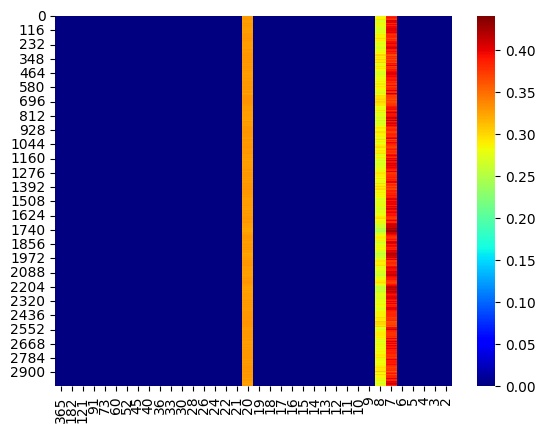

./weights_results\omdata1_topk3_MSPT_0725_custom_ftMS_sl365_ll48_pl15_dm256_nh8_el3_dl1_df1024_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


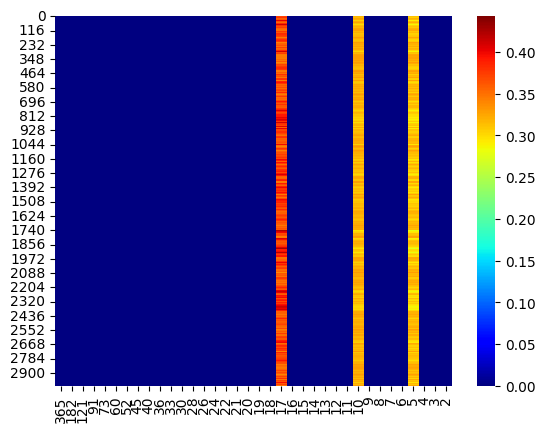

./weights_results\omdata1_topk3_MSPT_0725_custom_ftMS_sl365_ll48_pl20_dm128_nh8_el3_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


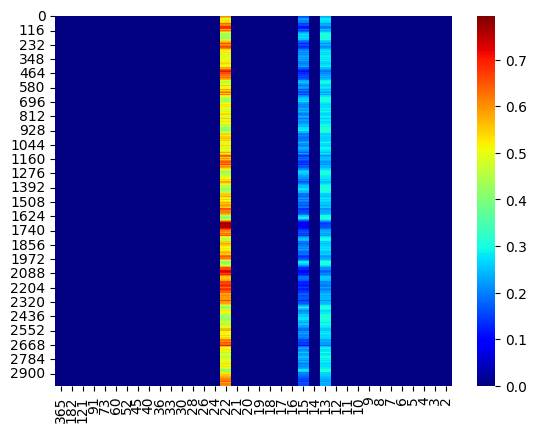

./weights_results\omdata1_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl30_dm128_nh8_el1_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


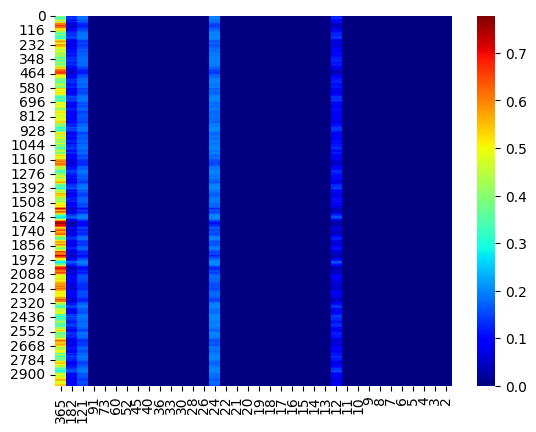

./weights_results\omdata2_topk4_MSPT_0725_custom_ftMS_sl365_ll48_pl10_dm128_nh8_el2_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


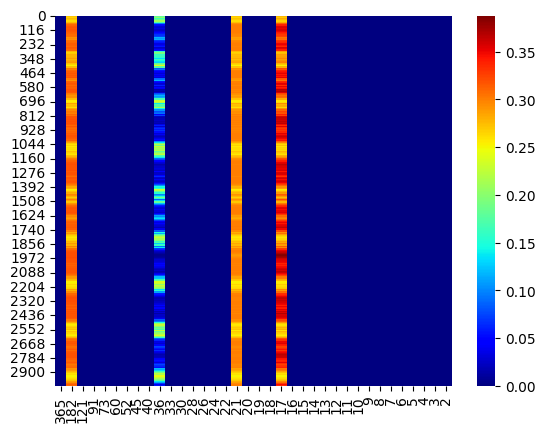

./weights_results\omdata2_topk4_MSPT_0725_custom_ftMS_sl365_ll48_pl15_dm128_nh8_el2_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


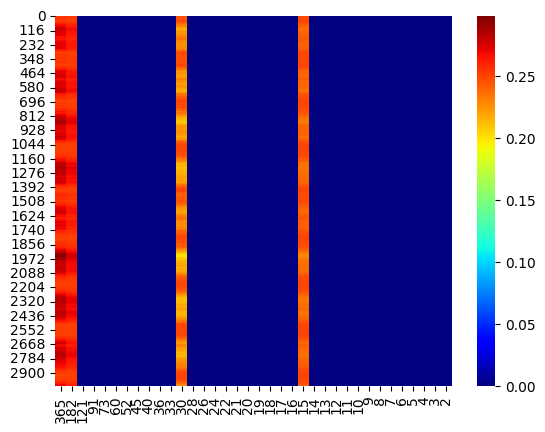

./weights_results\omdata2_topk4_MSPT_0725_custom_ftMS_sl365_ll48_pl25_dm128_nh8_el1_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


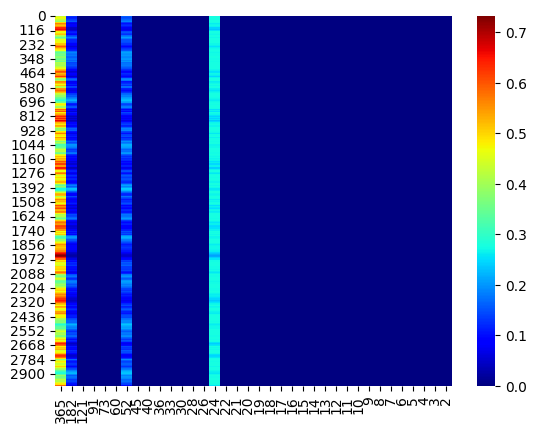

./weights_results\omdata2_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl20_dm128_nh8_el1_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


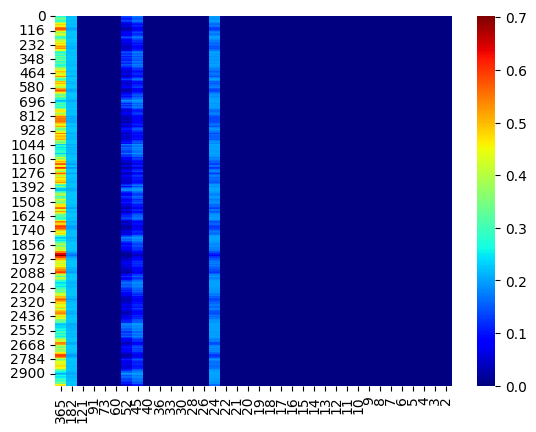

./weights_results\omdata2_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl30_dm128_nh8_el1_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


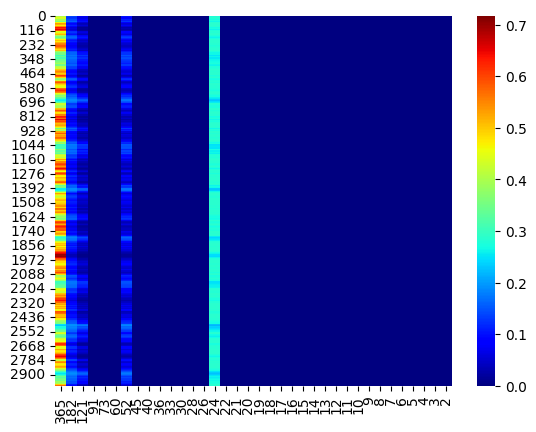

./weights_results\omdata3_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl10_dm256_nh8_el1_dl1_df1024_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


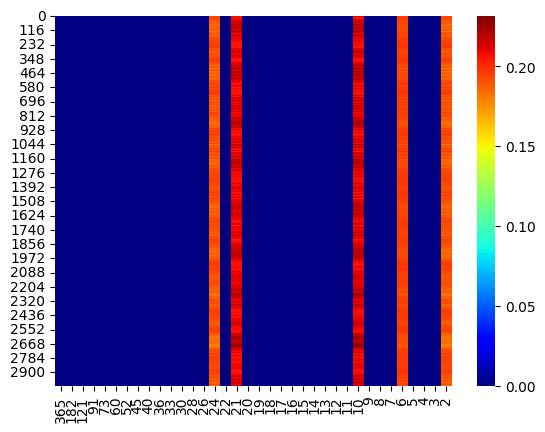

./weights_results\omdata4_topk2_MSPT_0725_custom_ftMS_sl365_ll48_pl15_dm128_nh8_el3_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


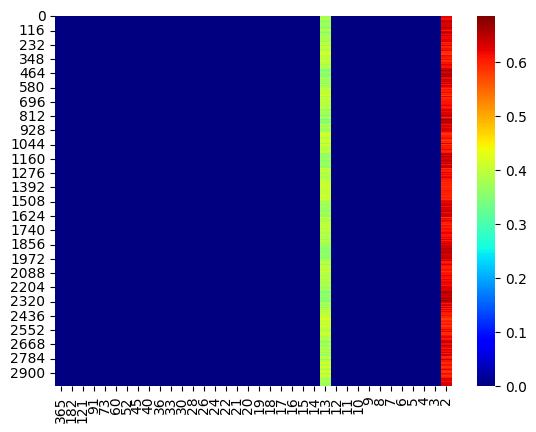

./weights_results\omdata4_topk2_MSPT_0725_custom_ftMS_sl365_ll48_pl25_dm128_nh8_el2_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


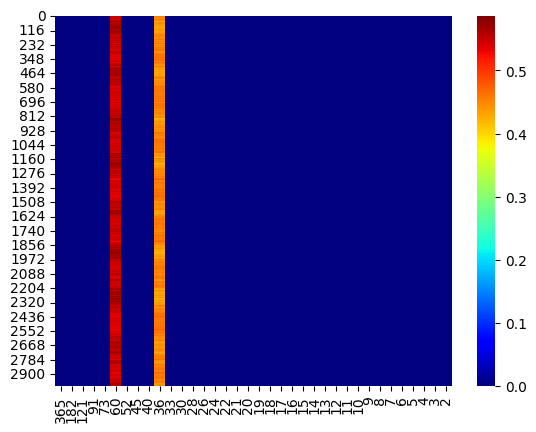

./weights_results\omdata4_topk4_MSPT_0725_custom_ftMS_sl365_ll48_pl10_dm256_nh8_el3_dl1_df1024_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


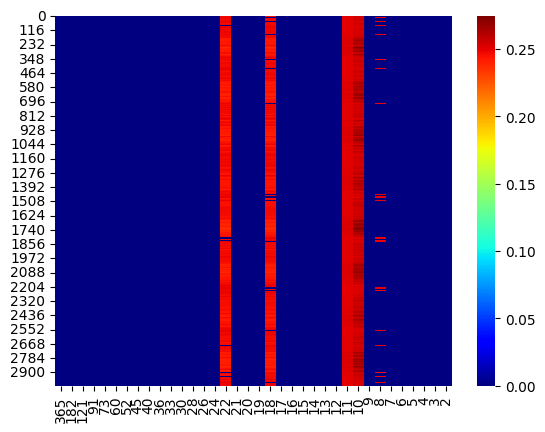

./weights_results\omdata4_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl20_dm128_nh8_el3_dl1_df512_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


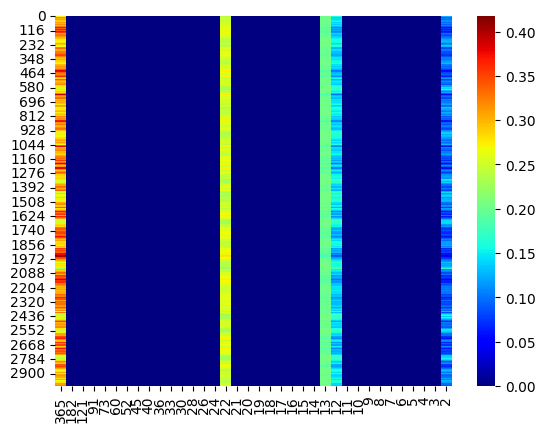

./weights_results\omdata4_topk5_MSPT_0725_custom_ftMS_sl365_ll48_pl30_dm256_nh8_el3_dl1_df1024_fc1_ebtimeF_dtTrue_20240701_0\weights.npy


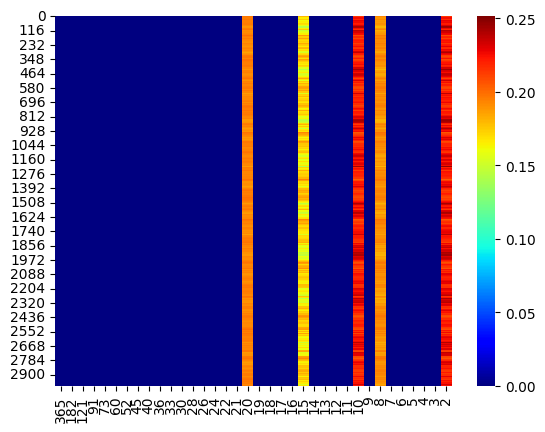

In [14]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

weights_results = glob.glob('./weights_results/*/weights.npy')

for weights_file in weights_results:
    weights = np.load(weights_file)
    print(weights_file)
    periods = [365, 182, 121,  91,  73,  60,  52,  45,  40,  36,  33,  30,  28,  26 , 24,  22  ,21  ,20 ,19  ,18 , 17,  16 , 15  ,14  ,13 , 12  ,11  ,10  , 9  , 8  , 7   ,6  , 5 ,  4  , 3 ,  2]
    
    sns.heatmap(weights, cmap='jet')
    plt.xticks(np.arange(0.5, len(periods), 1), labels=periods, rotation=90)
    plt.show()

In [21]:
import torch
peroid_list = 1 / torch.fft.rfftfreq(365)[1:]
peroid_list = peroid_list.unfold(-1, 2, 1).mean(-1)
patch_sizes = peroid_list.floor().int().unique().detach().cpu().numpy()[::-1]
patch_sizes

array([273, 152, 106,  82,  66,  56,  48,  43,  38,  34,  31,  29,  27,
        25,  23,  22,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,
        10,   9,   8,   7,   6,   5,   4,   3,   2])